In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with Linear Autoencoder

In [3]:
np.random.seed(123)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

In [4]:
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [6]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))
autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 2)                 8         
_________________________________________________________________
sequential_4 (Sequential)    (None, 3)                 9         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 5ms/step - loss: 0.1417
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0984
Epoch 3/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4229
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3932
Epoch 5/20
2/2 [==============================] - 0s 4ms/step - loss: 0.1242
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0741
Epoch 7/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0369
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0265
Epoch 9/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0208
Epoch 10/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0157
Epoch 11/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 12/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 13/20
2/2 [==============================] - 0s 0s/step - loss: 0.0

In [8]:
codings = encoder.predict(X_train)

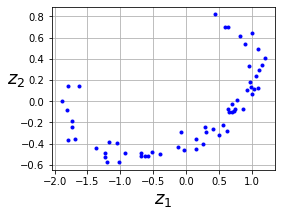

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

# Stacked Autoencoder

In [6]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [17]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3374 - rounded_accuracy: 0.8882 - val_loss: 0.3107 - val_rounded_accuracy: 0.9124
Epoch 2/20
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3050 - rounded_accuracy: 0.9159 - val_loss: 0.3017 - val_rounded_accuracy: 0.9195s - loss: 0.3053 - 
Epoch 3/20
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2986 - rounded_accuracy: 0.9216 - val_loss: 0.2990 - val_rounded_accuracy: 0.9255
Epoch 4/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2949 - rounded_accuracy: 0.9248 - val_loss: 0.2950 - val_rounded_accuracy: 0.9236
Epoch 5/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2923 - rounded_accuracy: 0.9270 - val_loss: 0.2921 - val_rounded_accuracy: 0.9289
Epoch 6/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2903 - rounded_accuracy: 0.9289 - val_loss: 0.3027 - val_rounded_accuracy: 0.9052
Epoch 7/20
1719

In [18]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for index in range(n_images):
        plt.subplot(2, n_images, index+1)
        plot_image(images[index])
        plt.subplot(2, n_images, index+n_images+1)
        plot_image(reconstructions[index])

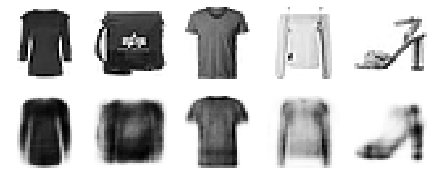

In [23]:
show_reconstructions(stacked_ae)

In [25]:
from sklearn.manifold import TSNE

X_valid_compressor = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressor)
X_valid_2D = (X_valid_2D - X_valid_2D.min())/(X_valid_2D.max() - X_valid_2D.min())

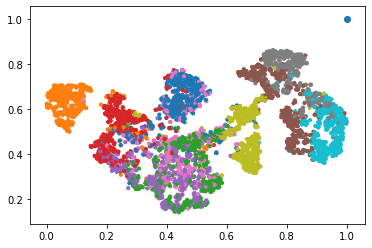

In [40]:
plt.scatter(X_valid_2D[:,0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.scatter(1, 1)
plt.show()

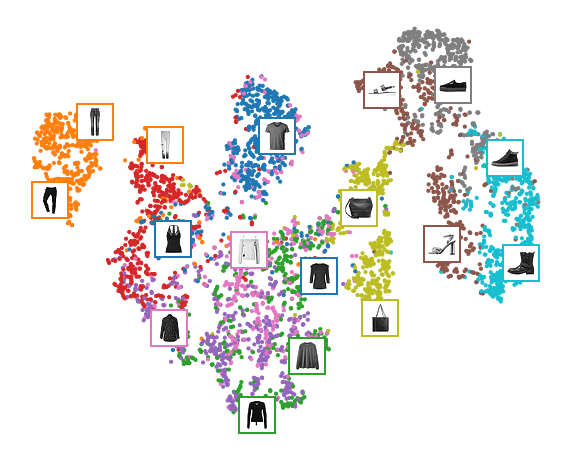

In [66]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((image_positions - position)**2, axis=1)
    if dist.min()>0.02:
        image_positions = np.r_[image_positions, [position]]
        image_box = mpl.offsetbox.AnnotationBbox(mpl.offsetbox.OffsetImage(X_valid[index], cmap='binary'),
                                                position, bboxprops={'edgecolor':cmap(y_valid[index]), 'lw':2})
        plt.gca().add_artist(image_box)

plt.axis("off")
plt.show()

## Tying Weights

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', initializer='zeros',
                                     shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z+self.biases)

In [68]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])

tied_ae.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 30)                81530     
_________________________________________________________________
sequential_10 (Sequential)   (None, 28, 28)            82414     
Total params: 82,414
Trainable params: 82,414
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3279 - rounded_accuracy: 0.8948 - val_loss: 0.3053 - val_rounded_accuracy: 0.9195
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2971 - rounded_accuracy: 0.9223 - val_loss: 0.2967 - val_rounded_accuracy: 0.9205
Epoch 3/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2914 - rounded_accuracy: 0.9277 - val_loss: 0.2988 - val_rounded_accuracy: 0.9276
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2885 - rounded_accuracy: 0.9303 - val_loss: 0.2880 - val_rounded_accuracy: 0.9312
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2864 - rounded_accuracy: 0.9322 - val_loss: 0.2865 - val_rounded_accuracy: 0.9325
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2849 - rounded_accuracy: 0.9336 - val_loss: 0.2853 - val_rounded_accuracy: 0.9356
Epoch 7/10
1719/1719 [============

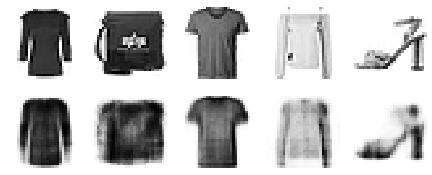

In [70]:
show_reconstructions(tied_ae)
plt.show()

## Training One Autoencoder at a time

In [ ]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [72]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100, X_train_flat, X_valid_flat, "binary_crossentropy",
                        keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
                        output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3450 - rounded_accuracy: 0.8870 - val_loss: 0.3116 - val_rounded_accuracy: 0.9151
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3032 - rounded_accuracy: 0.9211 - val_loss: 0.2999 - val_rounded_accuracy: 0.9253
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2943 - rounded_accuracy: 0.9293 - val_loss: 0.2928 - val_rounded_accuracy: 0.9324
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2887 - rounded_accuracy: 0.9347 - val_loss: 0.2884 - val_rounded_accuracy: 0.9366
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2850 - rounded_accuracy: 0.9382 - val_loss: 0.2853 - val_rounded_accuracy: 0.9393
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2824 - rounded_accuracy: 0.9407 - val_loss: 0.2831 - val_rounded_accuracy: 0.9415
Epoch 7/10
1719/1719 [============

In [73]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

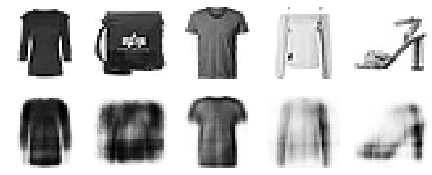

In [74]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [75]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9353
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2854 - rounded_accuracy: 0.9358 - val_loss: 0.2872 - val_rounded_accuracy: 0.9355
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2853 - rounded_accuracy: 0.9360 - val_loss: 0.2870 - val_rounded_accuracy: 0.9354
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2851 - rounded_accuracy: 0.9361 - val_loss: 0.2868 - val_rounded_accuracy: 0.9358
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2850 - rounded_accuracy: 0.9362 - val_loss: 0.2868 - val_rounded_accuracy: 0.9362
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2849 - rounded_accuracy: 0.9363 - val_loss: 0.2867 - val_rounded_accuracy: 0.9365
Epoch 7/10
1719/1719 [============

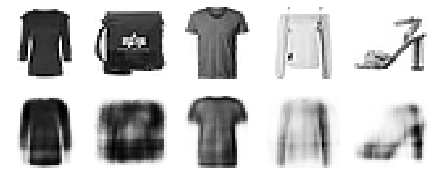

In [76]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

# Using ConvolutionLayers in Autoencoder

In [77]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_encoder.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

In [80]:
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_decoder.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_6 (Reshape)          (None, 28, 28)            0         
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________


In [81]:
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
conv_ae.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_19 (Sequential)   (None, 3, 3, 64)          23296     
_________________________________________________________________
sequential_22 (Sequential)   (None, 28, 28)            23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 72s 42ms/step - loss: 0.3022 - rounded_accuracy: 0.9186 - val_loss: 0.2823 - val_rounded_accuracy: 0.9368
Epoch 2/5
1719/1719 [==============================] - 84s 49ms/step - loss: 0.2767 - rounded_accuracy: 0.9406 - val_loss: 0.2758 - val_rounded_accuracy: 0.9412
Epoch 3/5
1719/1719 [==============================] - 70s 41ms/step - loss: 0.2715 - rounded_accuracy: 0.9457 - val_loss: 0.2740 - val_rounded_accuracy: 0.9401
Epoch 4/5
1719/1719 [==============================] - 59s 34ms/step - loss: 0.2687 - rounded_accuracy: 0.9485 - val_loss: 0.2686 - val_rounded_accuracy: 0.9498
Epoch 5/5
1719/1719 [==============================] - 84s 49ms/step - loss: 0.2668 - rounded_accuracy: 0.9506 - val_loss: 0.2707 - val_rounded_accuracy: 0.9469


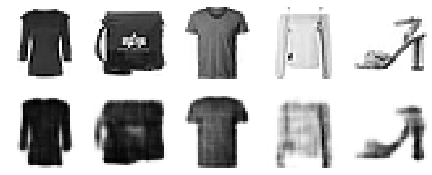

In [83]:
show_reconstructions(conv_ae)
plt.show()

# Recurrent Autoencoder

In [88]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])
recurrent_decoder.summary()
recurrent_ae.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_3 (RepeatVecto (None, 28, 30)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 28, 64)            24320     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 28, 28)            1820      
Total params: 26,140
Trainable params: 26,140
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_33 (Sequential)   (None, 30)                35208     
_________________________________________________________________
sequential_34 (Sequential)   (None, 28, 28)            26140     
Total params: 61,348
Train

In [90]:
history = recurrent_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 206s 120ms/step - loss: 0.5004 - rounded_accuracy: 0.7592 - val_loss: 0.4436 - val_rounded_accuracy: 0.8225
Epoch 2/5
1719/1719 [==============================] - 151s 88ms/step - loss: 0.4034 - rounded_accuracy: 0.8414 - val_loss: 0.3920 - val_rounded_accuracy: 0.8500
Epoch 3/5
1719/1719 [==============================] - 184s 107ms/step - loss: 0.3686 - rounded_accuracy: 0.8679 - val_loss: 0.3618 - val_rounded_accuracy: 0.8764
Epoch 4/5
1719/1719 [==============================] - 198s 115ms/step - loss: 0.3560 - rounded_accuracy: 0.8769 - val_loss: 0.3532 - val_rounded_accuracy: 0.8816
Epoch 5/5
1719/1719 [==============================] - 180s 105ms/step - loss: 0.3473 - rounded_accuracy: 0.8831 - val_loss: 0.3457 - val_rounded_accuracy: 0.8870


In [ ]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder

In [91]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])

denoising_ae.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_36 (Sequential)   (None, 30)                81530     
_________________________________________________________________
sequential_37 (Sequential)   (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [92]:
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3511 - rounded_accuracy: 0.8774 - val_loss: 0.3199 - val_rounded_accuracy: 0.9073
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3139 - rounded_accuracy: 0.9080 - val_loss: 0.3096 - val_rounded_accuracy: 0.9135
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3068 - rounded_accuracy: 0.9141 - val_loss: 0.3041 - val_rounded_accuracy: 0.9188
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3025 - rounded_accuracy: 0.9180 - val_loss: 0.3011 - val_rounded_accuracy: 0.9201
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2997 - rounded_accuracy: 0.9204 - val_loss: 0.2988 - val_rounded_accuracy: 0.9244
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss: 0.2955 - val_rounded_accuracy: 0.9259
Epoch 7/10
1719/1719 [============

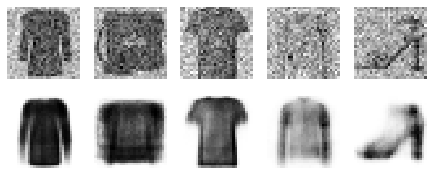

In [93]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

### Using Dropout :-

In [94]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])

dropout_ae.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_39 (Sequential)   (None, 30)                81530     
_________________________________________________________________
sequential_40 (Sequential)   (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [95]:
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3549 - rounded_accuracy: 0.8727 - val_loss: 0.3210 - val_rounded_accuracy: 0.8993
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3186 - rounded_accuracy: 0.9026 - val_loss: 0.3120 - val_rounded_accuracy: 0.9104
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3126 - rounded_accuracy: 0.9074 - val_loss: 0.3070 - val_rounded_accuracy: 0.9134
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3089 - rounded_accuracy: 0.9106 - val_loss: 0.3039 - val_rounded_accuracy: 0.9169
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3065 - rounded_accuracy: 0.9126 - val_loss: 0.3025 - val_rounded_accuracy: 0.9195
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3045 - rounded_accuracy: 0.9142 - val_loss: 0.3003 - val_rounded_accuracy: 0.9207
Epoch 7/10
1719/1719 [============

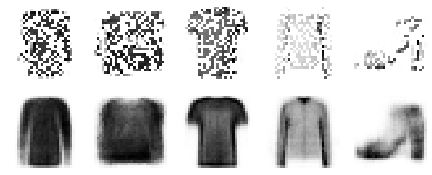

In [96]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()

# Sparse Autoencoder

First create a simple stacked Autoencoder so that we can compare it later with the sparse one

In [98]:
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])

history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4407 - rounded_accuracy: 0.7879 - val_loss: 0.3809 - val_rounded_accuracy: 0.8489
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3664 - rounded_accuracy: 0.8616 - val_loss: 0.3580 - val_rounded_accuracy: 0.8787
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3458 - rounded_accuracy: 0.8817 - val_loss: 0.3433 - val_rounded_accuracy: 0.8844
Epoch 4/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3362 - rounded_accuracy: 0.8898 - val_loss: 0.3344 - val_rounded_accuracy: 0.8876
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3269 - rounded_accuracy: 0.8977 - val_loss: 0.3252 - val_rounded_accuracy: 0.9005
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3213 - rounded_accuracy: 0.9016 - val_loss: 0.3210 - val_rounded_accuracy: 0.9036
Epoch 7/10
1719/1719 [============

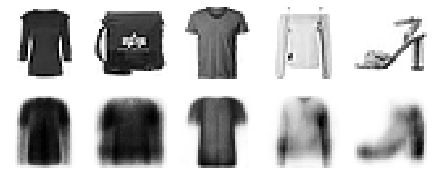

In [99]:
show_reconstructions(simple_ae)
plt.show()

In [7]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    X = bins[:-1] + widths/2
    ax.bar(X, counts/len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
                                 lambda y, position: '{}%'.format(int(np.round(y*100)))))
    ax.grid(True)

In [8]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins+1)
    
    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

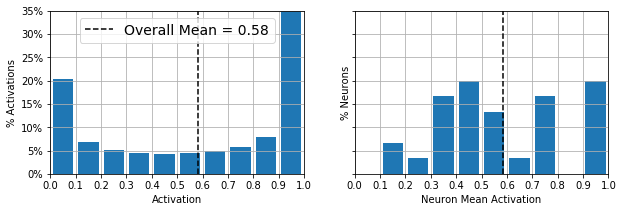

In [114]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Use L1 regularization in the coding layer

In [116]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])

sparse_l1_ae.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_48 (Sequential)   (None, 300)               108800    
_________________________________________________________________
sequential_49 (Sequential)   (None, 28, 28)            109284    
Total params: 218,084
Trainable params: 218,084
Non-trainable params: 0
_________________________________________________________________


In [117]:
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4287 - rounded_accuracy: 0.8177 - val_loss: 0.3812 - val_rounded_accuracy: 0.8547
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3686 - rounded_accuracy: 0.8690 - val_loss: 0.3638 - val_rounded_accuracy: 0.8736
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3555 - rounded_accuracy: 0.8789 - val_loss: 0.3528 - val_rounded_accuracy: 0.8847
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3447 - rounded_accuracy: 0.8864 - val_loss: 0.3436 - val_rounded_accuracy: 0.8863
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3379 - rounded_accuracy: 0.8914 - val_loss: 0.3370 - val_rounded_accuracy: 0.8935
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3309 - val_rounded_accuracy: 0.8991
Epoch 7/10
1719/1719 [============

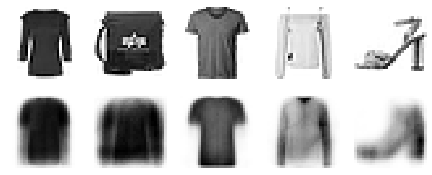

In [118]:
show_reconstructions(sparse_l1_ae)

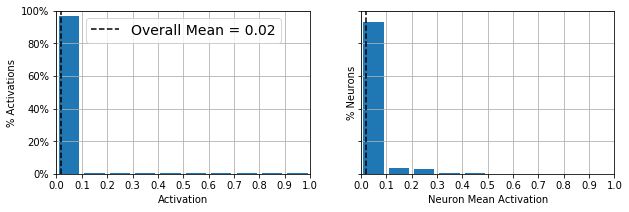

In [120]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

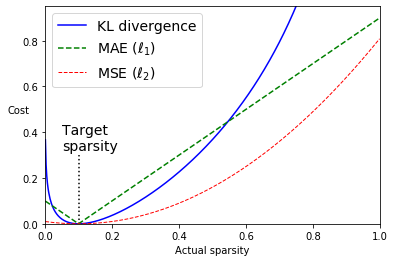

In [121]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.show()

In [9]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class MyKLRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activations = K.mean(inputs, axis=0)
        return self.weight*(kl_divergence(self.target, mean_activations) +
                                            kl_divergence(1. - self.target, 1. - mean_activations))

In [131]:
kld_reg = MyKLRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])

sparse_kl_ae.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_52 (Sequential)   (None, 300)               108800    
_________________________________________________________________
sequential_53 (Sequential)   (None, 28, 28)            109284    
Total params: 218,084
Trainable params: 218,084
Non-trainable params: 0
_________________________________________________________________


In [132]:
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4171 - rounded_accuracy: 0.8099 - val_loss: 0.3714 - val_rounded_accuracy: 0.8577
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3521 - rounded_accuracy: 0.8781 - val_loss: 0.3431 - val_rounded_accuracy: 0.8863
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3336 - rounded_accuracy: 0.8927 - val_loss: 0.3295 - val_rounded_accuracy: 0.8991
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3219 - rounded_accuracy: 0.9027 - val_loss: 0.3206 - val_rounded_accuracy: 0.9058
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3162 - rounded_accuracy: 0.9072 - val_loss: 0.3163 - val_rounded_accuracy: 0.9083
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3127 - rounded_accuracy: 0.9100 - val_loss: 0.3133 - val_rounded_accuracy: 0.9111
Epoch 7/10
1719/1719 [============

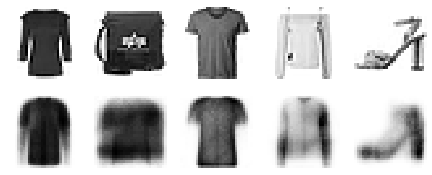

In [134]:
show_reconstructions(sparse_kl_ae)
plt.show()

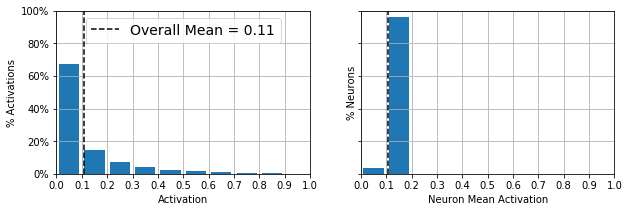

In [135]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

# Variational Autoencoder

In [34]:
class sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var))*K.exp(log_var/2) + mean

In [37]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstruction = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstruction])

latent_loss = -0.5*K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
# /784 is becoz keras divide the output loss by the total no. of outputs after their sum, So this is to scale. 
variational_ae.add_loss(K.mean(latent_loss)/784.)

variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
variational_ae.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model_24 (Model)                [(None, 10), (None,  134870      input_20[0][0]                   
__________________________________________________________________________________________________
model_25 (Model)                (None, 28, 28)       134634      model_24[1][2]                   
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 784)          0           input_20[0][0]                   
___________________________________________________________________________________________

In [38]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 7s 15ms/step - loss: 0.3909 - rounded_accuracy: 0.8613 - val_loss: 0.3463 - val_rounded_accuracy: 0.8975
Epoch 2/25
430/430 [==============================] - 9s 21ms/step - loss: 0.3434 - rounded_accuracy: 0.8976 - val_loss: 0.3393 - val_rounded_accuracy: 0.9049
Epoch 3/25
430/430 [==============================] - 10s 23ms/step - loss: 0.3332 - rounded_accuracy: 0.9052 - val_loss: 0.3322 - val_rounded_accuracy: 0.9088
Epoch 4/25
430/430 [==============================] - 9s 21ms/step - loss: 0.3281 - rounded_accuracy: 0.9090 - val_loss: 0.3294 - val_rounded_accuracy: 0.9090
Epoch 5/25
430/430 [==============================] - 8s 18ms/step - loss: 0.3250 - rounded_accuracy: 0.9115 - val_loss: 0.3275 - val_rounded_accuracy: 0.9071
Epoch 6/25
430/430 [==============================] - 8s 18ms/step - loss: 0.3228 - rounded_accuracy: 0.9135 - val_loss: 0.3232 - val_rounded_accuracy: 0.9165
Epoch 7/25
430/430 [=========================

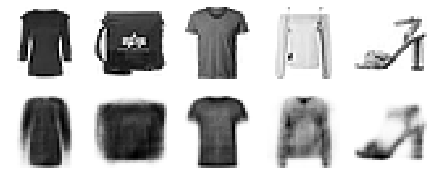

In [39]:
show_reconstructions(variational_ae)
plt.show()

In [64]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

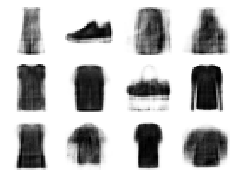

In [67]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

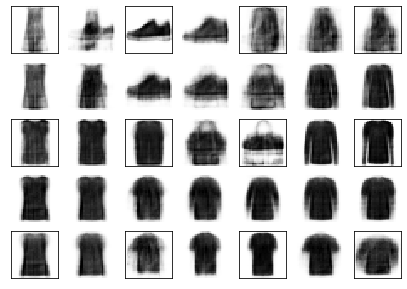

In [68]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

# GANs

In [70]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28)            136634    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 132951    
Total params: 269,585
Trainable params: 269,585
Non-trainable params: 0
_________________________________________________________________


In [71]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
# setting trainable=False would not set the discriminator non-trainabe in discriminator model becoz it is already compiled
# But it would be non-trainable in gan
discriminator.trainable = False 
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [72]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [77]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=10):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     
        plt.show()        

Epoch 1/1


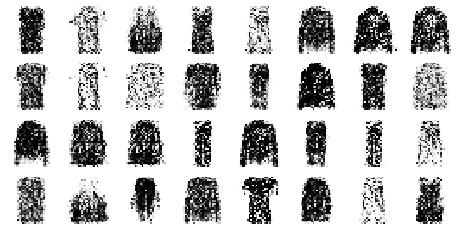

In [74]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

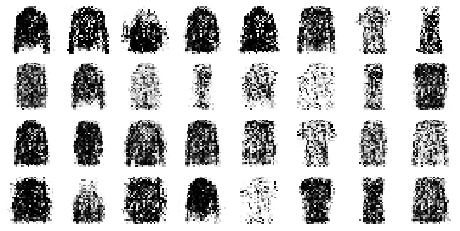

In [75]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

Epoch 1/50


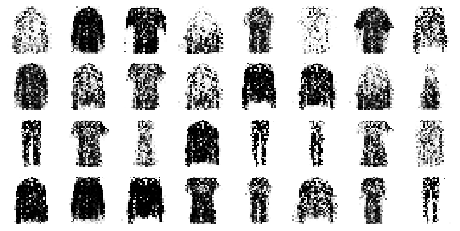

Epoch 2/50


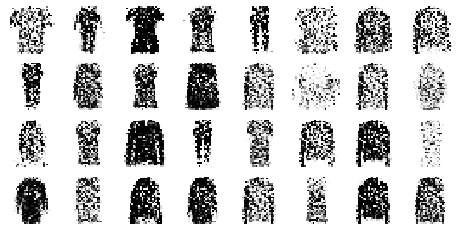

Epoch 3/50


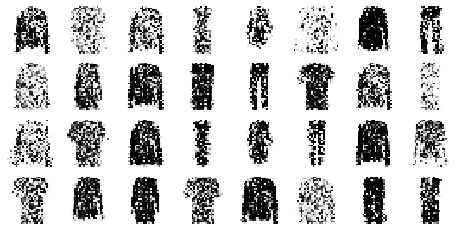

Epoch 4/50


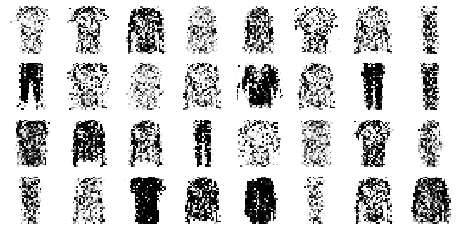

Epoch 5/50


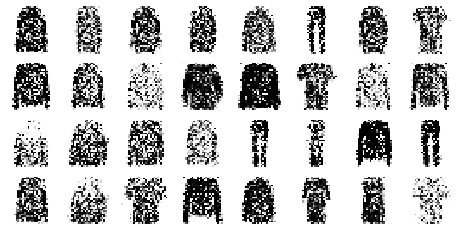

Epoch 6/50


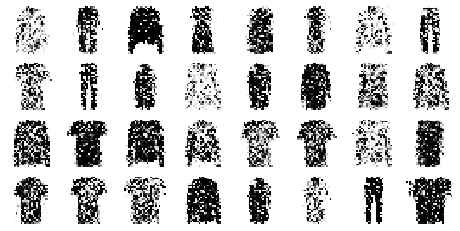

Epoch 7/50


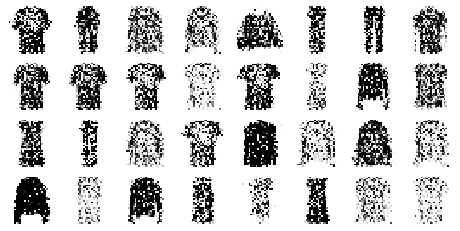

Epoch 8/50


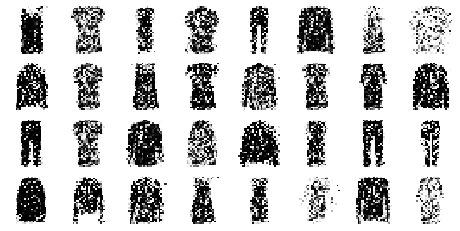

Epoch 9/50


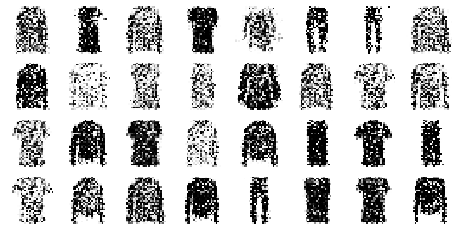

Epoch 10/50


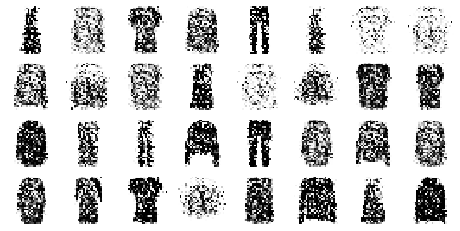

Epoch 11/50


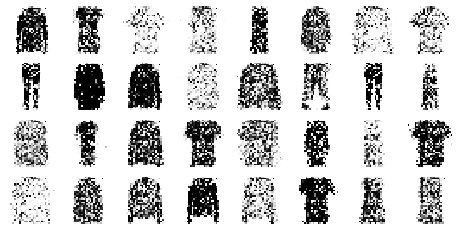

Epoch 12/50


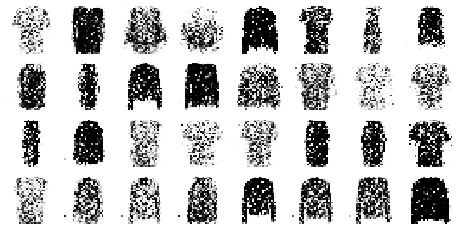

Epoch 13/50


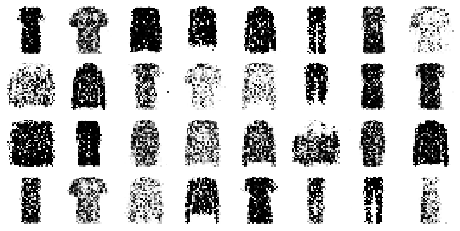

Epoch 14/50


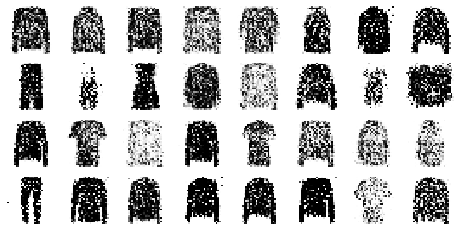

Epoch 15/50


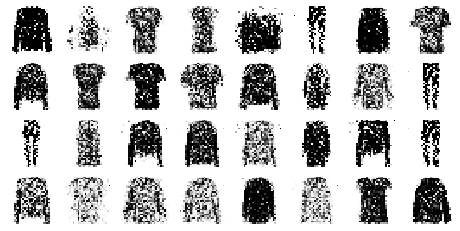

Epoch 16/50


KeyboardInterrupt: 

In [76]:
train_gan(gan, dataset, batch_size, codings_size)

## DCGAN

In [78]:
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [79]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [80]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [81]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/10


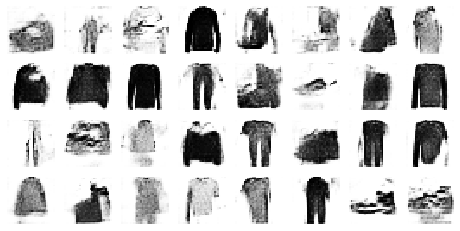

Epoch 2/10


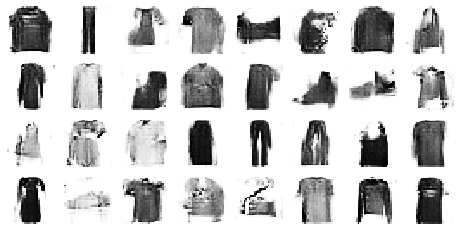

Epoch 3/10


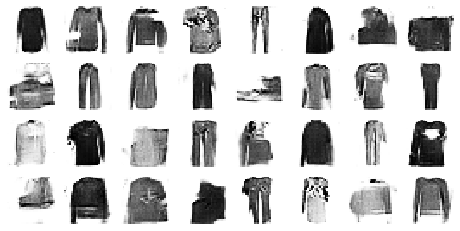

Epoch 4/10


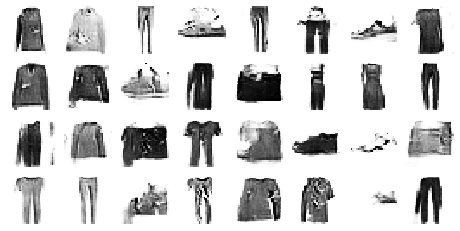

Epoch 5/10


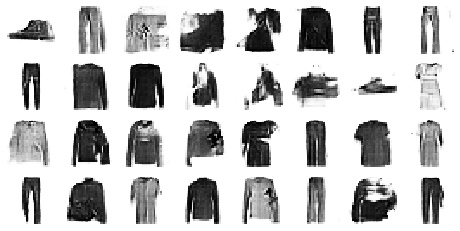

Epoch 6/10


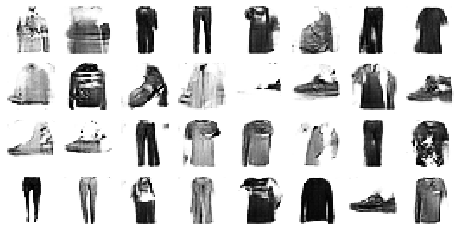

Epoch 7/10


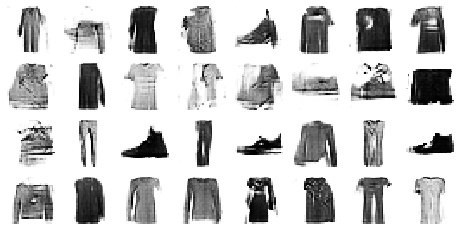

Epoch 8/10


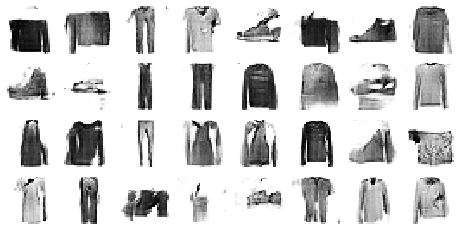

Epoch 9/10


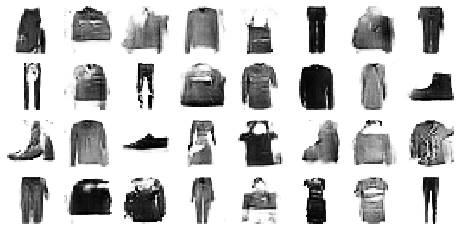

Epoch 10/10


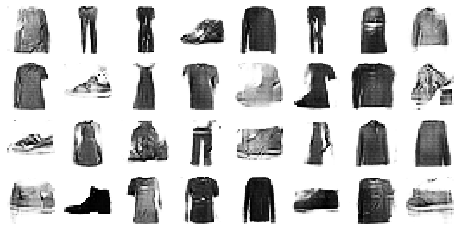

In [82]:
train_gan(gan, dataset, batch_size, codings_size)

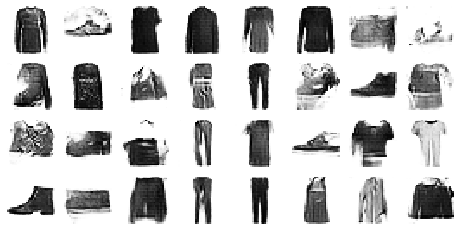

In [83]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)